In [8]:
#importandoa as biblioetcas usadas para a preparação dos dados e predição
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
#importando as biblioteca da api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
#buscando todos os jogos
result = leaguegamefinder.LeagueGameFinder()
todosJogos = result.get_data_frames()[0]

ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)

In [5]:
#tranformando os dados da api em um dataframe
df = pd.DataFrame(todosJogos)
#df['GAME_DATE']

0        2019-11-06
1        2019-11-06
2        2019-11-06
3        2019-11-06
4        2019-11-06
            ...    
29995    2013-04-17
29996    2013-04-17
29997    2013-04-17
29998    2013-04-17
29999    2013-04-17
Name: GAME_DATE, Length: 30000, dtype: object

In [16]:
#retirando os dados que nao sera usado na api
    df.drop(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID','GAME_DATE', 'MATCHUP'], axis=1, inplace=True)
df.head()

,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,L,240,109,43,93,0.462,10,32,0.313,13,...,0.765,10,38,48,24,4,4,14,24,-4.0
1,L,239,128,45,78,0.577,19,34,0.559,19,...,0.760,4,32,36,21,7,4,18,21,-1.0
2,L,240,104,40,94,0.426,11,32,0.344,13,...,0.591,17,39,56,25,7,5,16,25,-11.0
3,L,239,109,37,95,0.389,12,35,0.343,23,...,0.852,8,31,39,21,11,4,17,18,-22.0
4,W,240,93,36,85,0.424,5,29,0.172,16,...,0.696,16,32,48,18,6,1,12,15,6.0


In [17]:
df['WL'] = pd.get_dummies(df['WL'])

In [18]:
#Transformando os dados categóricos de  WINorLOSS para numeros
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['WL'])
df['WL'] = df['WL'].fillna(df['WL'].mean())
df['WL'] = le.transform(df['WL'])

In [19]:
#importando para separar dos dados de teste e de treino
from sklearn.model_selection import train_test_split

In [20]:
#separando a base de dados
x = df.drop('WL',axis=1)
x = x.fillna(x.mean())
y = df['WL']
y = y.fillna(y.mean())

In [21]:
#separando os dados de treino de teste sendo 40% para teste e 60% para treino e escolhedo o um random 
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y,test_size=0.3,random_state=101)
aux = y_teste.reset_index()
aux.drop('index',axis=1,inplace=True)

In [22]:
#importando o algoritmo de floresta aleatoria e escolhendo a quantidade de arvores
from sklearn.ensemble import RandomForestClassifier
floA = RandomForestClassifier(n_estimators=200)

In [23]:
floA.fit(x_treino,y_treino)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
predicao = floA.predict(x_teste)

Text(0, 0.5, 'Y valor predito')

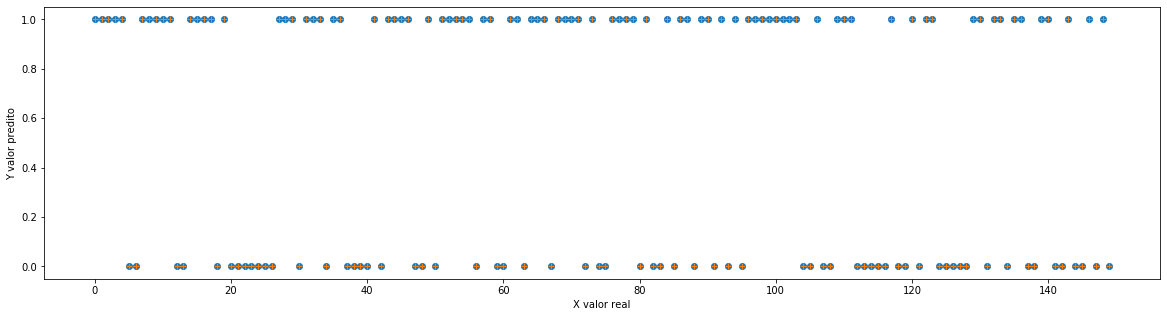

In [25]:
plt.figure(figsize=(20,5))
plt.plot(aux[:150], 'o')
plt.plot(predicao[:150], '+')
plt.xlabel('X valor real')
plt.ylabel('Y valor predito')

In [26]:
from sklearn import metrics
#MAE é o mais fácil de entender, porque é o erro médio.
#MSE é mais popular que o MAE, porque a MSE "puniria" erros maiores, o que tende a ser útil no mundo real.
#RMSE é ainda mais popular do que MSE, porque o RMSE é interpretável nas unidades "y".
print('MAE:', metrics.mean_absolute_error(y_teste, predicao))
print('MSE:', metrics.mean_squared_error(y_teste, predicao))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_teste, predicao)))

MAE: 0.004888888888888889
MSE: 0.004888888888888889
RMSE: 0.0699205898780101


In [27]:
print('Variance score: %.2f' % floA.score(x_teste,aux))

Variance score: 1.00


In [28]:
#fazendo a predicao usando cross-valodation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(floA,x,y, cv=10)

In [29]:
print('Variance Cros-Validation rscore: %.2f' % max(scores))

Variance Cros-Validation rscore: 1.00


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_teste,predicao))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4449
           1       0.99      1.00      1.00      4551

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000



In [31]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_teste,predicao))

[[4424   25]
 [  19 4532]]
